# Imports

In [851]:
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import ttest_ind

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

# 1. Prepara los datos

## 1.1. Abre los archivos y examina los datos.

In [852]:
df_train = pd.read_csv(r'C:\Users\arq_c\OneDrive\Escritorio\TripleTen-local\SPRINT_12\datasets\gold_recovery_train.csv')
df_test = pd.read_csv(r'C:\Users\arq_c\OneDrive\Escritorio\TripleTen-local\SPRINT_12\datasets\gold_recovery_test.csv')
df_full = pd.read_csv(r'C:\Users\arq_c\OneDrive\Escritorio\TripleTen-local\SPRINT_12\datasets\gold_recovery_full.csv')

Se usará la característica 'date' para poder extraer valores posteriormente.

In [853]:
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_full.set_index('date', inplace=True)

In [854]:
# Lista con datos
data = {'df_full': df_full, 'df_train': df_train, 'df_test': df_test}

In [855]:
def data_check(df):
    df.info()
    print('####################')
    print('Complete duplicates = ', df.duplicated().sum())
    print('####################')
    print(df.isna().sum())
    print(df.isna().sum().sum())
    print('####################')
for key, value in data.items():
    print()
    print('###', key, '###')
    print()
    data_check(value)


### df_full ###

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au           

## 1.2. Comprueba que el cálculo de la recuperación sea correcto. 

Calcula la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento. Encuentra el EAM entre tus cálculos y los valores de la característica. Facilita los resultados.

In [856]:
# Needed columns for recovery calculation

feed_au = df_train['rougher.input.feed_au'] # Concentración de oro en la alimentación al proceso flotación
concentrate_au = df_train['rougher.output.concentrate_au'] # Concentración de oro en el concentrado tras la flotación
tail_au = df_train['rougher.output.tail_au'] # Concentración de oro en la cola tras la flotación
given_recovery = df_train['rougher.output.recovery'] # Valor objetivo

# Formula to calculate recovery RECUPERACIÓN = (C * (F - T)) / (F * (C - T)) * 100
def calculate_recovery(feed, concentrate, tail):
    
    denominator = feed * (concentrate - tail)
        # Implementa
    recovery = (concentrate * (feed - tail)) / denominator * 100
    return recovery

# Implement the recovery calculation
calculated_recovery = calculate_recovery(feed_au, concentrate_au, tail_au)

In [857]:
# Drop NaN 
mask = ~(given_recovery.isna() | calculated_recovery.isna()) # Filtrado de valores no nulos
mae = mean_absolute_error(given_recovery[mask], calculated_recovery[mask])
print(f"Mean Absolute Error (MAE): {mae:.6f}")

Mean Absolute Error (MAE): 0.000000


### **NOTAS**
- Los valores objetivo han sido correactamente calculados.

## 1.3. Analiza las características no disponibles en el conjunto de prueba. ¿Cuáles son estos parámetros? ¿Cuál es su tipo?

In [858]:
col_faltantes = [col for col in df_train.columns if col not in df_test.columns] # Lista de columnas en train que no están en test
print("Columnas faltantes en el conjunto de prueba:")
for c in col_faltantes:
    print(f"- {c}") # Muestra las columnas faltantes en test

Columnas faltantes en el conjunto de prueba:
- final.output.concentrate_ag
- final.output.concentrate_pb
- final.output.concentrate_sol
- final.output.concentrate_au
- final.output.recovery
- final.output.tail_ag
- final.output.tail_pb
- final.output.tail_sol
- final.output.tail_au
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_pb
- primary_cleaner.output.concentrate_sol
- primary_cleaner.output.concentrate_au
- primary_cleaner.output.tail_ag
- primary_cleaner.output.tail_pb
- primary_cleaner.output.tail_sol
- primary_cleaner.output.tail_au
- rougher.calculation.sulfate_to_au_concentrate
- rougher.calculation.floatbank10_sulfate_to_au_feed
- rougher.calculation.floatbank11_sulfate_to_au_feed
- rougher.calculation.au_pb_ratio
- rougher.output.concentrate_ag
- rougher.output.concentrate_pb
- rougher.output.concentrate_sol
- rougher.output.concentrate_au
- rougher.output.recovery
- rougher.output.tail_ag
- rougher.output.tail_pb
- rougher.output.tail_sol
- ro

In [859]:
targets = [ ]
output_features = [ ]
other = [ ]

for feature in col_faltantes:
    if 'recovery' in feature:
        targets.append(feature)
    elif '.output.' in feature:
        output_features.append(feature)
    else:
        other.append(feature)

print('Características faltantes clasificadas:')
print(f" - Targets: {len(targets)}")
print(f"{targets}")
print(f" - Output Features: {len(output_features)}")
print(f"{output_features}")
print(f" - Other: {len(other)}")
print(f"{other}")

Características faltantes clasificadas:
 - Targets: 2
['final.output.recovery', 'rougher.output.recovery']
 - Output Features: 28
['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol'

### **NOTAS**
- Las caracteristícas tipo **target**, faltan puesto que son predicciones.
- Las tipo **output**, son calculadas, no existen antes.
- Las tipo **other**, son medidas posteriores. 

## 1.4. Realiza el preprocesamiento de datos.

# 2. Analiza los datos

## 2.1. Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

In [860]:
metals = ['au', 'ag', 'pb']

# Etapas 
stages = ['rougher', 'primary_cleaner', 'secondary_cleaner', 'final']

# Lista de columnas de concentración
concentration_columns = []
for stage in stages:
    for metal in metals:
        if stage == 'secondary_cleaner':
            # Para secondary_cleaner, usar la sintaxis: secondary_cleaner.output.tail_metal
            col_name = f"{stage}.output.tail_{metal}"
        else:
            # Para las demás etapas, usar: stage.output.concentrate_metal
            col_name = f"{stage}.output.concentrate_{metal}"
        concentration_columns.append(col_name)

print("Columnas de concentración generadas:")
for col in concentration_columns:
    print(f"{col}")

Columnas de concentración generadas:
rougher.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
secondary_cleaner.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
final.output.concentrate_au
final.output.concentrate_ag
final.output.concentrate_pb


#### Gráficos `df_gold_recovery_full`

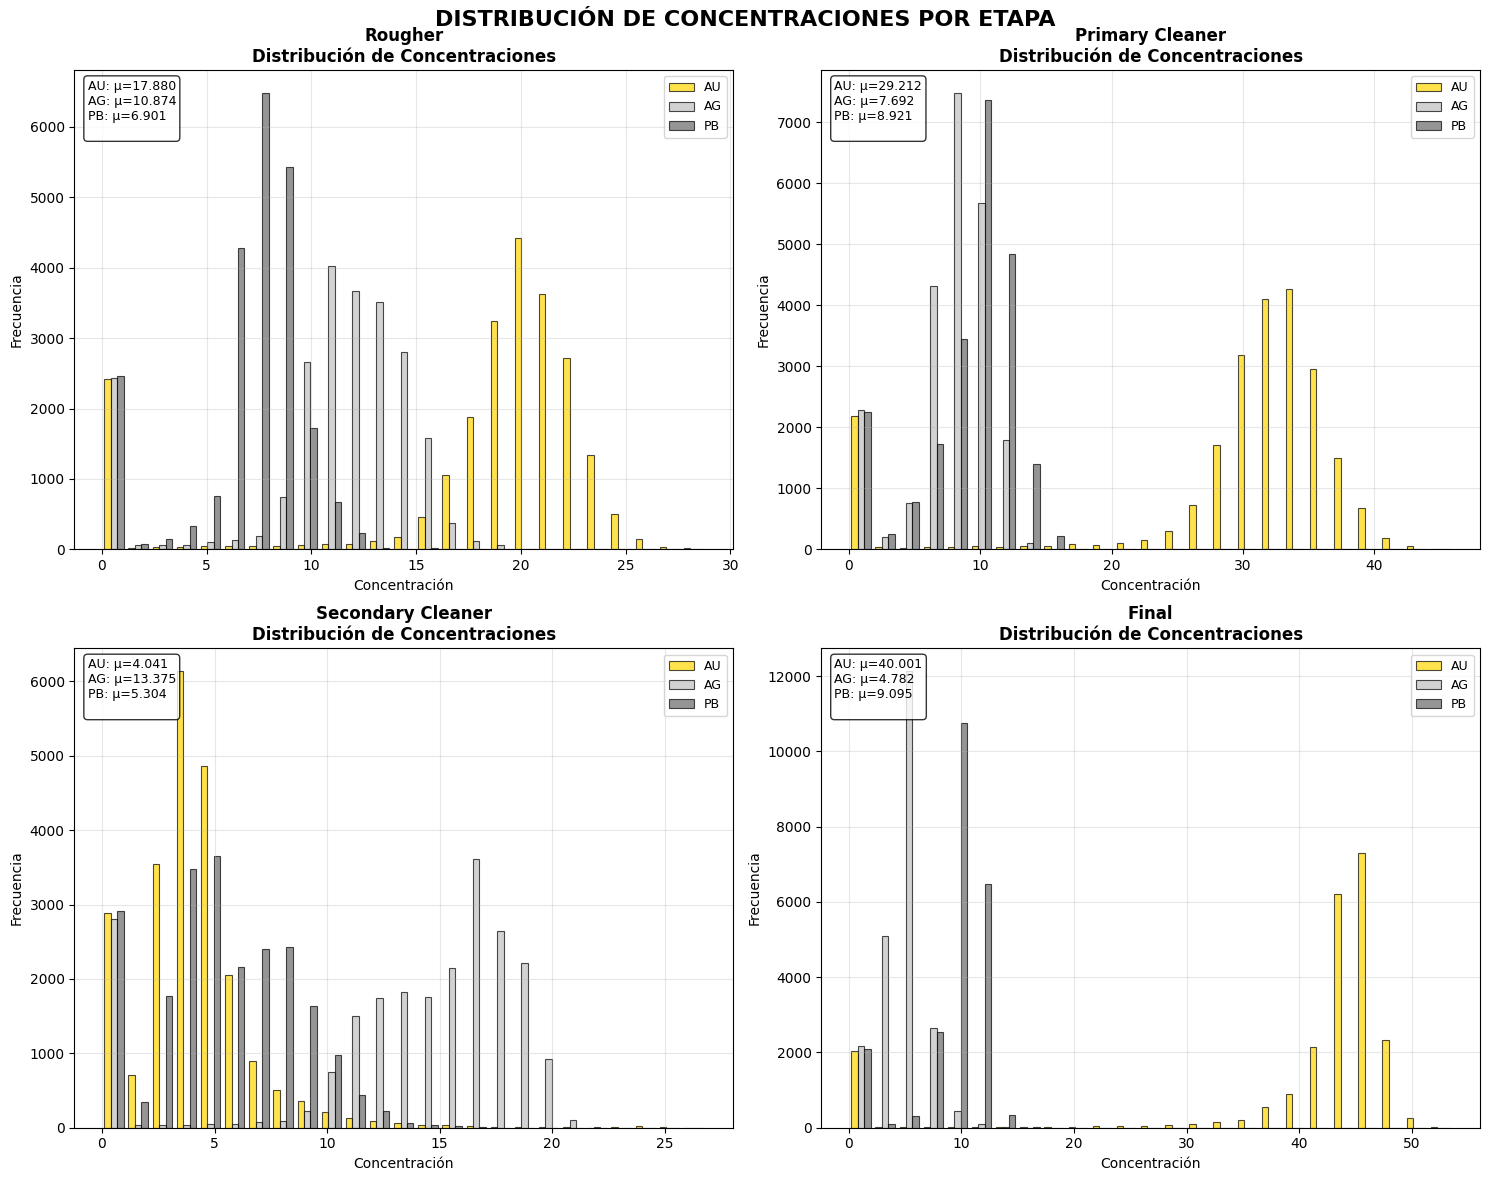

Datos disponibles por metal:
AU: 4 etapas - ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
AG: 4 etapas - ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
PB: 4 etapas - ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']


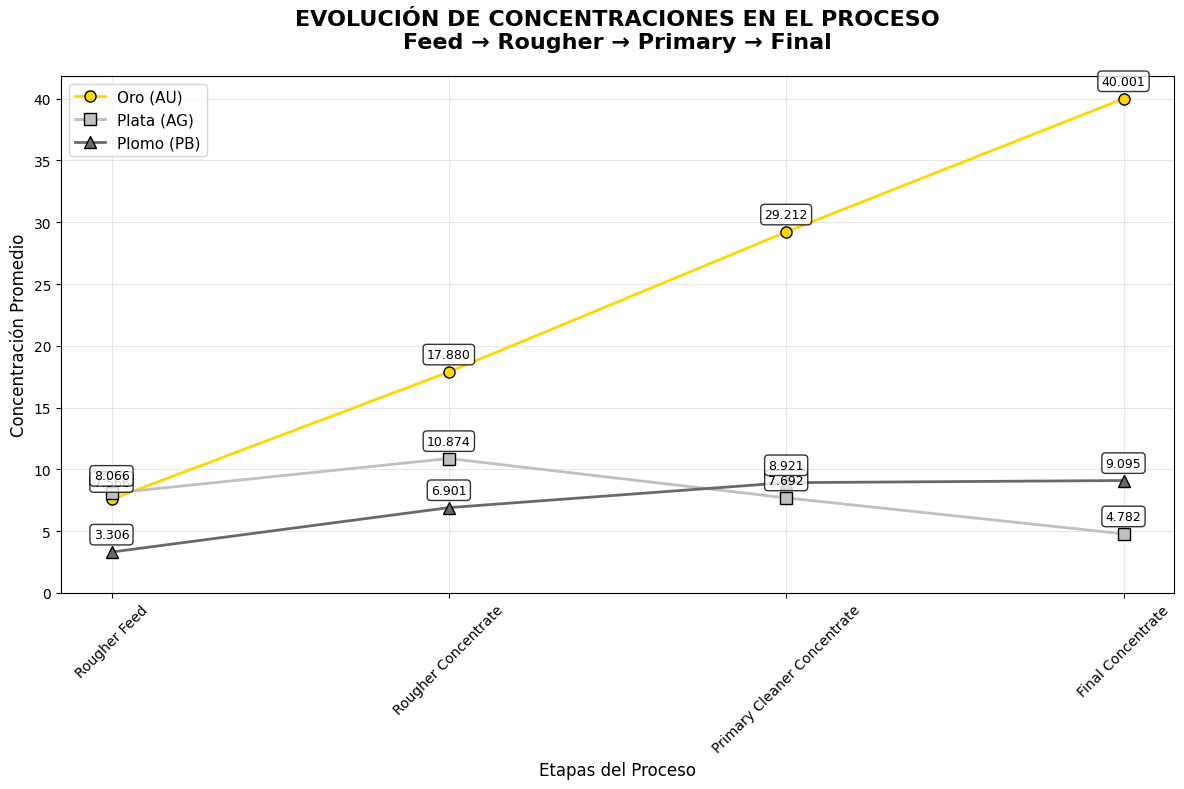

In [861]:
def plot_concentration_distributions_grid():
    """
    Grafica distribuciones en grid 2x2 - un gráfico por etapa
    """
    stages = ['rougher', 'primary_cleaner', 'secondary_cleaner', 'final']
    metals = ['au', 'ag', 'pb']
    metal_colors = ['gold', 'silver', 'dimgray']
    metal_names = ['AU', 'AG', 'PB']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, stage in enumerate(stages):
        ax = axes[i]
        
        # Verificar si la etapa tiene datos
        has_data = False
        data_to_plot = []
        
        for metal, color in zip(metals, metal_colors):
            if stage == 'secondary_cleaner':
                col_name = f'{stage}.output.tail_{metal}'
            else:
                col_name = f'{stage}.output.concentrate_{metal}'
            
            if col_name in df_full.columns:
                data = df_full[col_name].dropna()
                if len(data) > 0:
                    data_to_plot.append(data)
                    has_data = True
        
        if has_data:
            # Crear histograma
            n_bins = 25
            ax.hist(data_to_plot, bins=n_bins, alpha=0.7, 
                   color=metal_colors,  
                   edgecolor='black', linewidth=0.8, 
                   label=metal_names[:len(data_to_plot)])
            
            stage_name = stage.replace('_', ' ').title()
            ax.set_title(f'{stage_name}\nDistribución de Concentraciones', fontweight='bold', fontsize=12)
            ax.set_ylabel('Frecuencia', fontsize=10)
            ax.set_xlabel('Concentración', fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            
            # Añadir estadísticas en el gráfico
            stats_text = ""
            for j, (data, metal) in enumerate(zip(data_to_plot, metal_names[:len(data_to_plot)])):
                stats_text += f"{metal}: μ={data.mean():.3f}\n"
            
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.set_visible(False)
    
    # Ocultar ejes vacíos si hay menos de 4 etapas
    for i in range(len(stages), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('DISTRIBUCIÓN DE CONCENTRACIONES POR ETAPA', fontsize=16, fontweight='bold')
    plt.subplots_adjust(top=0.93)
    plt.show()

# Ejecutar la función grid
plot_concentration_distributions_grid()

###########################################################

def plot_concentration_changes_single():
    """
    Grafica cómo cambian las concentraciones por etapa - TODOS los metales en un gráfico
    """
    # Primero identificar qué metales y etapas tienen datos reales
    available_data = {}
    
    # Etapas específicas a analizar
    target_stages = [
        'rougher.input.feed',
        'rougher.output.concentrate', 
        'primary_cleaner.output.concentrate',
        'final.output.concentrate'
    ]
    
    for metal in ['au', 'ag', 'pb']:
        available_data[metal] = []
        for stage in target_stages:
            col_name = f'{stage}_{metal}'
            if col_name in df_full.columns:
                if not df_full[col_name].isnull().all():
                    available_data[metal].append(stage)
    
    print("Datos disponibles por metal:")
    for metal, stages in available_data.items():
        print(f"{metal.upper()}: {len(stages)} etapas - {stages}")
    
    # Crear un solo gráfico
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colores y marcadores para cada metal
    metal_colors = {'au': 'gold', 'ag': 'silver', 'pb': 'dimgray'}
    metal_markers = {'au': 'o', 'ag': 's', 'pb': '^'}
    metal_names = {'au': 'Oro (AU)', 'ag': 'Plata (AG)', 'pb': 'Plomo (PB)'}
    
    # Nombres display para las etapas
    stage_names_display = {
        'rougher.input.feed': 'Rougher Feed',
        'rougher.output.concentrate': 'Rougher Concentrate', 
        'primary_cleaner.output.concentrate': 'Primary Cleaner Concentrate',
        'final.output.concentrate': 'Final Concentrate'
    }
    
    # Graficar cada metal
    for metal in ['au', 'ag', 'pb']:
        if available_data[metal]:  # Si hay datos para este metal
            concentrations = []
            stage_indices = []
            stage_labels = []
            
            for stage in target_stages:
                if stage in available_data[metal]:
                    col_name = f'{stage}_{metal}'
                    concentrations.append(df_full[col_name].mean())
                    stage_indices.append(target_stages.index(stage))
                    stage_labels.append(stage_names_display[stage])
            
            # Graficar línea con puntos
            ax.plot(stage_indices, concentrations, 
                   marker=metal_markers[metal], 
                   color=metal_colors[metal],
                   linewidth=2, 
                   markersize=8,
                   label=metal_names[metal],
                   markerfacecolor=metal_colors[metal],
                   markeredgecolor='black',
                   markeredgewidth=1)
            
            # Añadir valores en los puntos
            for j, (x, y) in enumerate(zip(stage_indices, concentrations)):
                ax.annotate(f'{y:.3f}', 
                           (x, y), 
                           textcoords="offset points", 
                           xytext=(0,10), 
                           ha='center', 
                           fontsize=9,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Personalizar el gráfico
    ax.set_title('EVOLUCIÓN DE CONCENTRACIONES EN EL PROCESO\nFeed → Rougher → Primary → Final', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('Concentración Promedio', fontsize=12)
    ax.set_xlabel('Etapas del Proceso', fontsize=12)
    
    # Configurar eje X
    ax.set_xticks(range(len(target_stages)))
    ax.set_xticklabels([stage_names_display[stage] for stage in target_stages])
    ax.tick_params(axis='x', rotation=45)
    
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11, loc='best')
    
    # Añadir cuadrícula secundaria
    ax.grid(True, which='minor', alpha=0.2)
    
    # Ajustar límites del eje Y para mejor visualización
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()

# Ejecutar la función
plot_concentration_changes_single()

## NOTAS
- La concentración de Au (Oro) aumenta tras el paso de las etapas.
- La concentración de Plata disminuye.
- La concentración de Plomo aumenta.

## **2.2.** Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta.

In [862]:
# Encontrar columnas que contienen 'feed' y 'size'
data_train_feed_size = []
for column in df_train.columns:
    if 'feed_size' in column:
        data_train_feed_size.append(df_train[column])

data_test_feed_size = []
for column in df_test.columns:
    if 'feed_size' in column:
        data_test_feed_size.append(df_test[column])
# Creación de DataFrames con las columnas encontradas
data_train_feed_size = pd.DataFrame(data_train_feed_size).T # Transponer para facil uso en visualización
data_test_feed_size = pd.DataFrame(data_test_feed_size).T

# display(data_train_feed_size.head())
# display(data_test_feed_size.head())

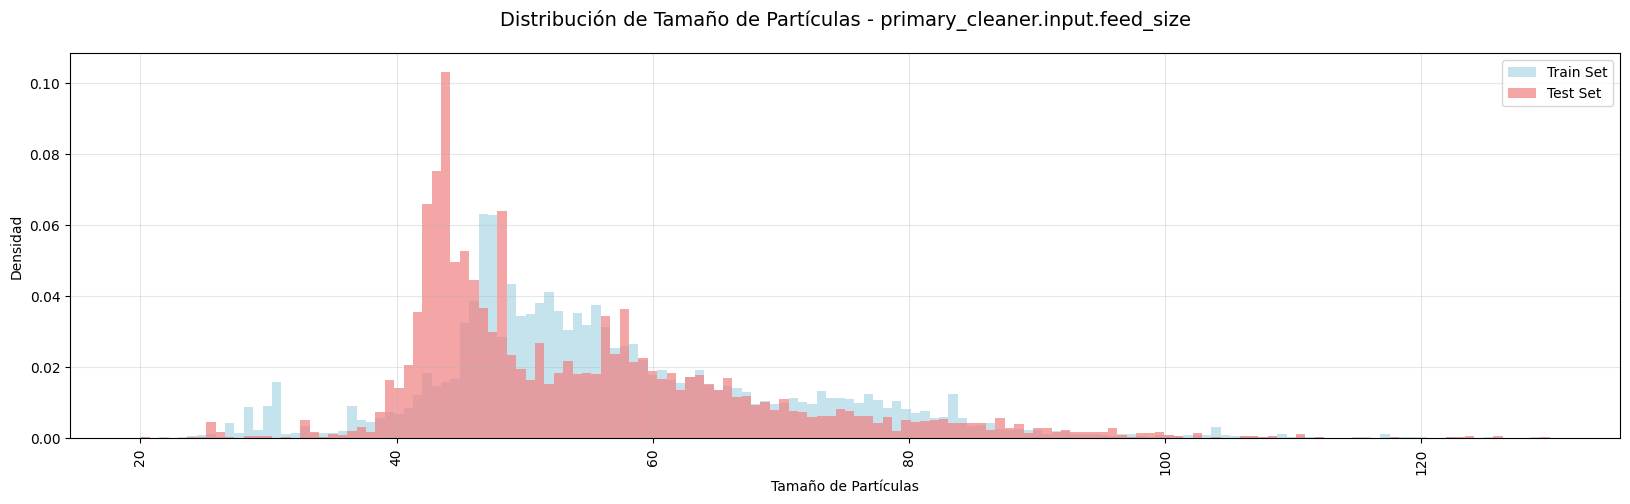

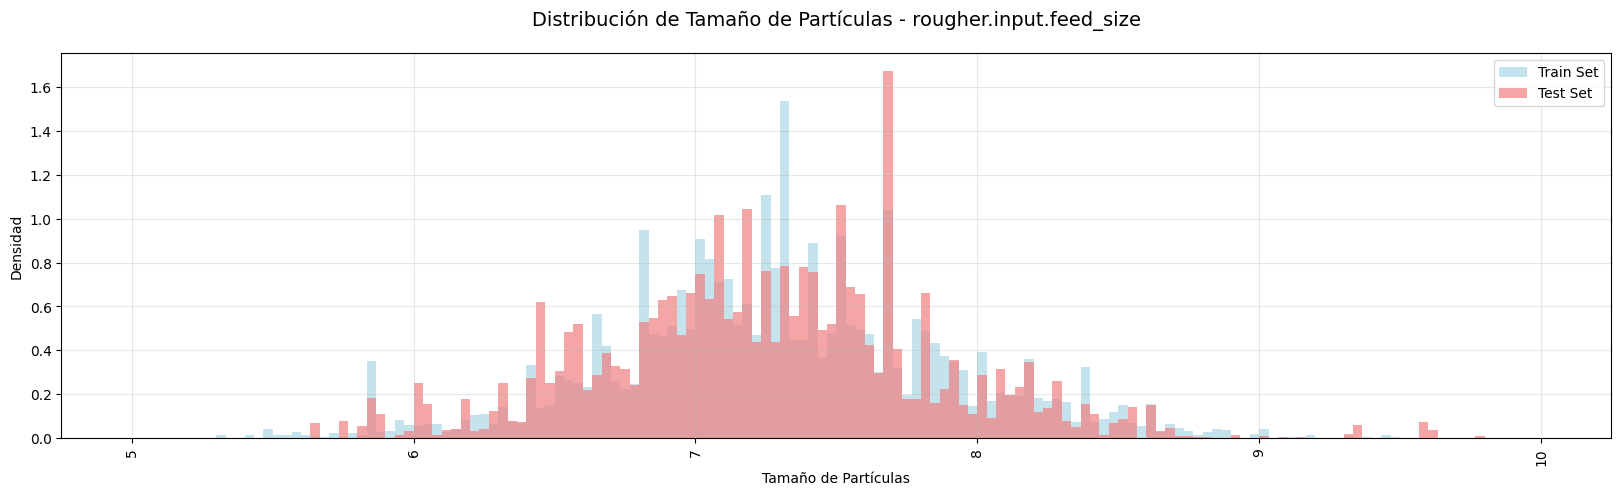

In [863]:
# primary_cleaner.input.feed_size
ax = data_train_feed_size.iloc[:,1].plot(
    kind='hist',
    bins=150,
    rot=90,
    figsize=(20, 5),
    alpha=0.7,  # Aumenté un poco la opacidad para mejor visualización
    range=(20, 130),
    density=True,
    color='lightblue',  # Train set = azul
    label='Train Set'
)
data_test_feed_size.iloc[:,1].plot(
    kind='hist',
    bins=150,
    rot=90,
    figsize=(20, 5),
    alpha=0.7,
    ax=ax,
    range=(20, 130),
    density=True,
    color='lightcoral',  # Test set = rojo claro
    label='Test Set'
)
plt.legend()
plt.title('Distribución de Tamaño de Partículas - primary_cleaner.input.feed_size', pad=20, fontsize=14)
plt.xlabel('Tamaño de Partículas')
plt.ylabel('Densidad')
plt.grid(alpha=0.3)
plt.show()

# rougher.input.feed_size
ax = data_train_feed_size.iloc[:,0].plot(
    kind='hist',
    bins=150,
    rot=90,
    figsize=(20, 5),
    alpha=0.7,
    range=(5, 10),
    density=True,
    color='lightblue',  # Train set = azul
    label='Train Set'
)
data_test_feed_size.iloc[:,0].plot(
    kind='hist',
    bins=150,
    rot=90,
    figsize=(20, 5),
    alpha=0.7,
    ax=ax,
    range=(5, 10),
    density=True,
    color='lightcoral',  # Test set = rojo claro
    label='Test Set'
)

plt.legend()
plt.title('Distribución de Tamaño de Partículas - rougher.input.feed_size', pad=20, fontsize=14)
plt.xlabel('Tamaño de Partículas')
plt.ylabel('Densidad')
plt.grid(alpha=0.3)
plt.show()

### Kolmogorov-Smirnov para evaluar diferencia de distribuciones

In [864]:
# Kolmogorov-Smirnov
# data_train_feed_size.info()
# data_test_feed_size.info()

# Borrar datos nulos
data_train_feed_size_clean = data_train_feed_size.dropna()
data_test_feed_size_clean = data_test_feed_size.dropna()

print(f"Training dataset size after cleaning: {len(data_train_feed_size_clean)}")
print(f"Test dataset size after cleaning: {len(data_test_feed_size_clean)}")

# Kolmogorov-Smirnov test para cada columna
columns = ['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

results = {}

for column in columns:
    # Extract the data FIRST before scaling
    train_data = data_train_feed_size_clean[column].values
    test_data = data_test_feed_size_clean[column].values
    
    # Scale the data for this specific column
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
    test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()
    
    # Perform KS test on SCALED data
    ks_statistic, p_value = st.ks_2samp(train_data_scaled, test_data_scaled)
    
    results[column] = {
        'Estadístico KS': ks_statistic,
        'Valor P': p_value,
        'Tamaño Muestra Entrenamiento': len(train_data),
        'Tamaño Muestra Prueba': len(test_data)
    }
    
    print(f"\n--- {column} ---")
    print(f"Estadístico KS: {ks_statistic:.6f}")
    print(f"Valor P: {p_value:.6f}")
    print(f"Tamaños de muestra: Entrenamiento = {len(train_data)}, Prueba = {len(test_data)}")
    
    # Interpretar los resultados
    alpha = 0.05
    if p_value < alpha:
        print("Resultado: Las distribuciones son significativamente diferentes (rechazar H0)")
    else:
        print("Resultado: No hay diferencia significativa en las distribuciones (no se rechaza H0)")

Training dataset size after cleaning: 16443
Test dataset size after cleaning: 5834

--- primary_cleaner.input.feed_size ---
Estadístico KS: 0.043899
Valor P: 0.000000
Tamaños de muestra: Entrenamiento = 16443, Prueba = 5834
Resultado: Las distribuciones son significativamente diferentes (rechazar H0)

--- rougher.input.feed_size ---
Estadístico KS: 0.192311
Valor P: 0.000000
Tamaños de muestra: Entrenamiento = 16443, Prueba = 5834
Resultado: Las distribuciones son significativamente diferentes (rechazar H0)


### TTest para evaluar diferencia de distribuciones


In [865]:
for col1, col2, in zip(data_train_feed_size_clean.columns, data_test_feed_size_clean.columns):
    t_stat, p_val = ttest_ind(data_train_feed_size_clean[col1], data_test_feed_size_clean[col2], equal_var=False)
    print(f"\n--- T-Test entre {col1} y {col2} ---")
    print(f"Estadístico T: {t_stat:.6f}")
    print(f"Valor P: {p_val:.6f}")
    
    alpha = 0.05
    if p_val < alpha:
        print("Resultado: Las medias son significativamente diferentes (rechazar H0)")
    else:
        print("Resultado: No hay diferencia significativa en las medias (no se rechaza H0)")


--- T-Test entre primary_cleaner.input.feed_size y primary_cleaner.input.feed_size ---
Estadístico T: 2.687359
Valor P: 0.007214
Resultado: Las medias son significativamente diferentes (rechazar H0)

--- T-Test entre rougher.input.feed_size y rougher.input.feed_size ---
Estadístico T: 7.799435
Valor P: 0.000000
Resultado: Las medias son significativamente diferentes (rechazar H0)


### NOTAS
- Ambos test revelan un diferencia en las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba.

## 2.3. Considera las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. 

¿Observas algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras? Describe los resultados y elimina las anomalías.

In [866]:
# Las tres etapas principales
nomenclatura = ['rougher.input.feed', 'rougher.output.concentrate', 'rougher.output.tail' , 'final.output.concentrate', 'final.output.tail']

# Sustancias principales (metales)
substances = ['au', 'ag', 'pb']

print("Etapas del proceso, para analisis de concentraciones:") # Combinación de stages y substances
stages_list = []
for stage in nomenclatura:
    for substance in substances:
        print(f"- {stage}_{substance}")
        stages_list.append(f"{stage}_{substance}")

Etapas del proceso, para analisis de concentraciones:
- rougher.input.feed_au
- rougher.input.feed_ag
- rougher.input.feed_pb
- rougher.output.concentrate_au
- rougher.output.concentrate_ag
- rougher.output.concentrate_pb
- rougher.output.tail_au
- rougher.output.tail_ag
- rougher.output.tail_pb
- final.output.concentrate_au
- final.output.concentrate_ag
- final.output.concentrate_pb
- final.output.tail_au
- final.output.tail_ag
- final.output.tail_pb


In [867]:
# Filtrar el DataFrame para incluir solo las columnas de stages_list
df_concentration = df_full[stages_list].copy()

# Eliminar valores nulos
# Eliminar filas con valores nulos y luego eliminar filas donde todas las concentraciones son 0
df_concentration = df_concentration.dropna()
df_concentration = df_concentration[(df_concentration != 0).any(axis=1)]

print(f"DataFrame original: {df_full.shape}")
print(f"DataFrame filtrado (concentraciones): {df_concentration.shape}")

# Mostrar las primeras filas
# print("\nPrimeras 5 filas del DataFrame de concentraciones:")
# display(df_concentration.head())

# print(df_concentration.info())

DataFrame original: (22716, 86)
DataFrame filtrado (concentraciones): (19823, 15)


### Gráfico de concentraciones

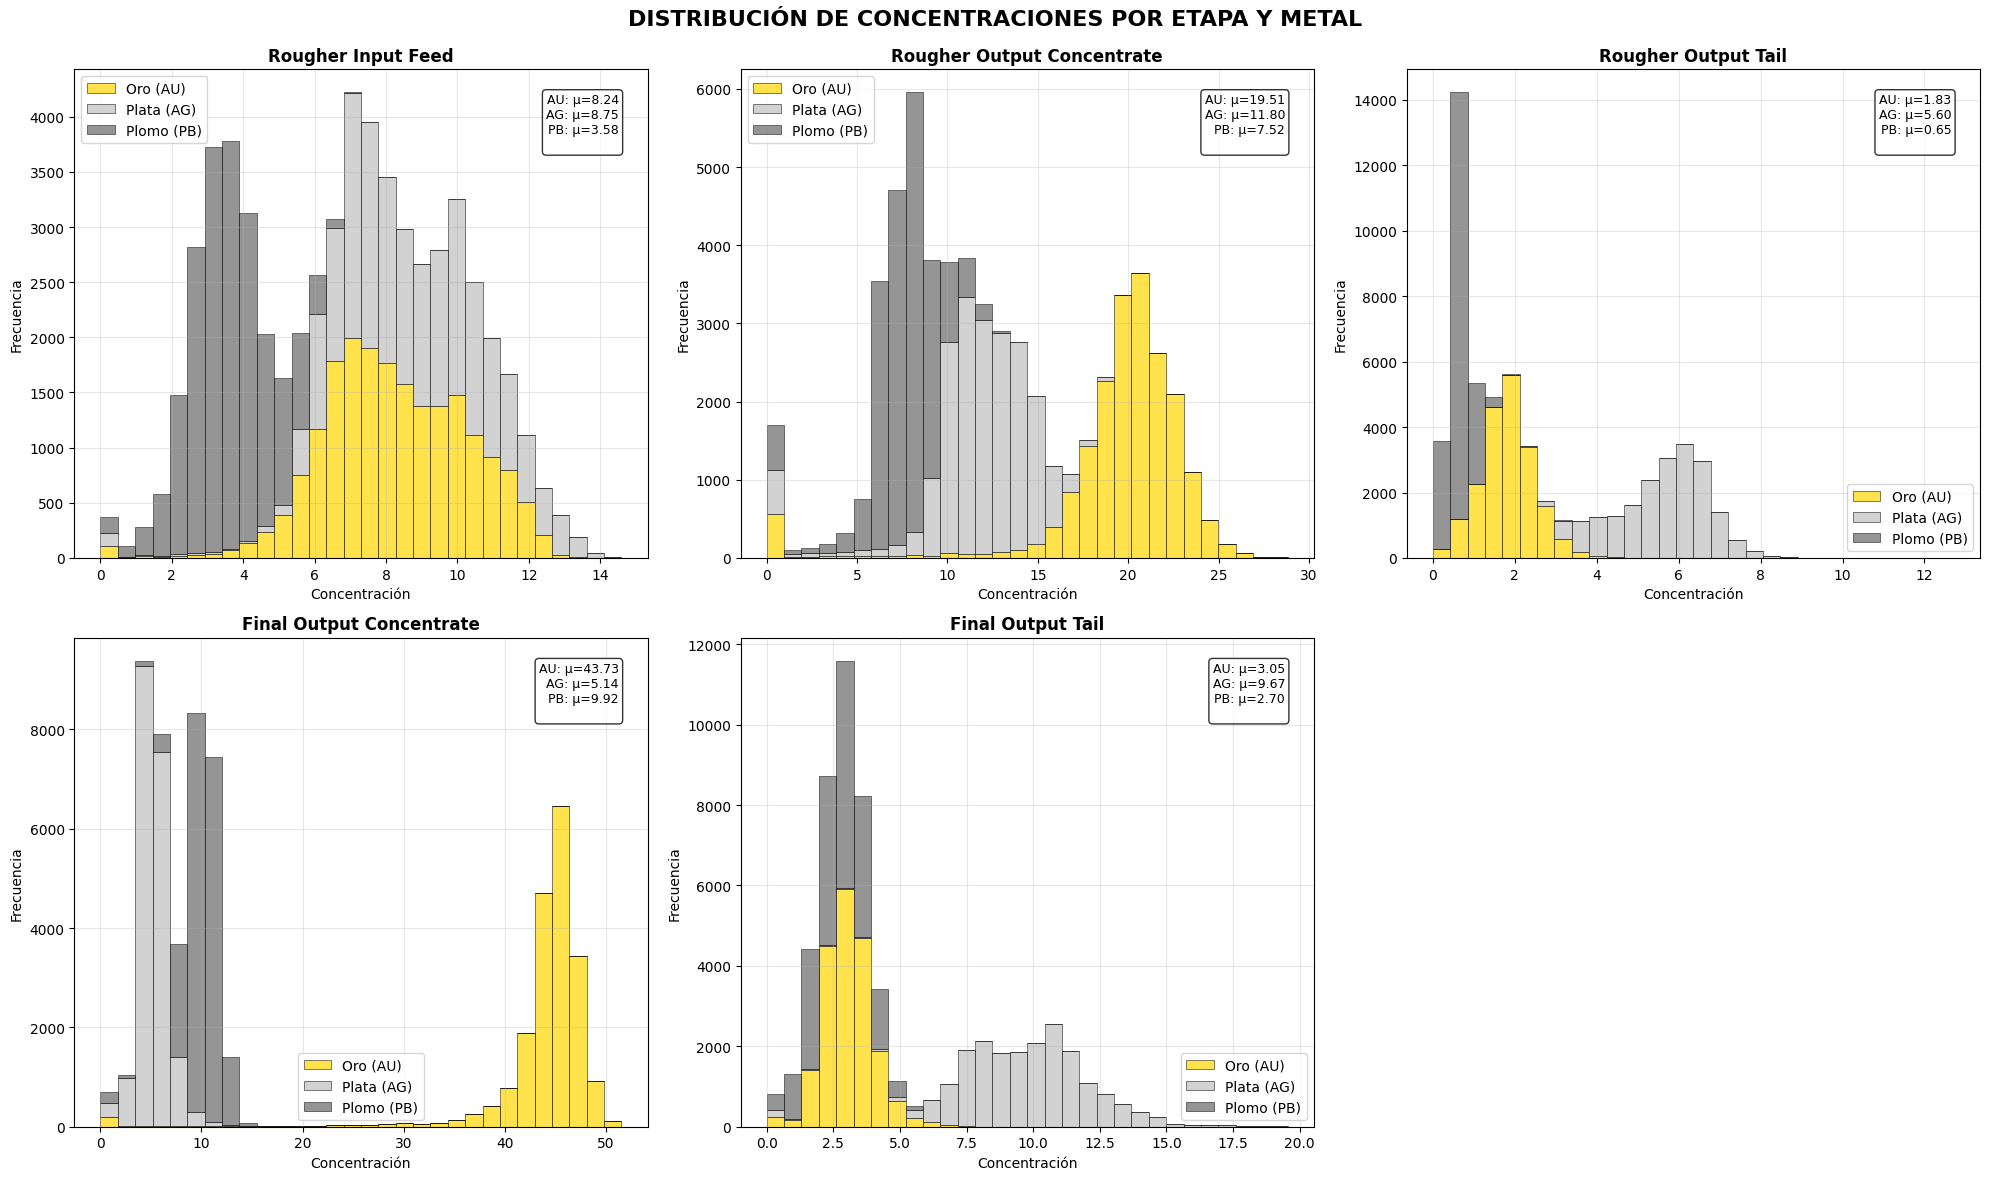

In [868]:
# Configurar el estilo
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('DISTRIBUCIÓN DE CONCENTRACIONES POR ETAPA Y METAL', fontsize=16, fontweight='bold')

# Definir etapas y metales
etapas = [
    'rougher.input.feed',
    'rougher.output.concentrate', 
    'rougher.output.tail',
    'final.output.concentrate',
    'final.output.tail'
]

nombres_etapas = [
    'Rougher Input Feed',
    'Rougher Output Concentrate',
    'Rougher Output Tail',
    'Final Output Concentrate', 
    'Final Output Tail'
]

metales = ['au', 'ag', 'pb']
nombres_metales = ['Oro (AU)', 'Plata (AG)', 'Plomo (PB)']
nombres_metales_leyenda = ['AU', 'AG', 'PB']
colores = ['gold', 'silver', 'dimgray']

# Crear gráficos para cada etapa
for i, (etapa, nombre_etapa) in enumerate(zip(etapas, nombres_etapas)):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Preparar datos para esta etapa
    datos_etapa = []
    for metal in metales:
        col_name = f"{etapa}_{metal}"
        if col_name in df_concentration.columns:
            datos_etapa.append(df_concentration[col_name].values)
        else:
            datos_etapa.append([])
    
    # Crear histograma para los 3 metales
    n_bins = 30
    ax.hist(datos_etapa, bins=n_bins, alpha=0.7, label=nombres_metales, 
            color=colores, edgecolor='black', linewidth=0.5, stacked=True)
    
    # Personalizar el gráfico
    ax.set_title(nombre_etapa, fontweight='bold', fontsize=12)
    ax.set_xlabel('Concentración')
    ax.set_ylabel('Frecuencia')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Añadir estadísticas en el gráfico
    stats_text = ""
    for j, metal in enumerate(metales):
        col_name = f"{etapa}_{metal}"
        if col_name in df_concentration.columns:
            data = df_concentration[col_name]
            stats_text += f"{nombres_metales_leyenda[j][0:2]}: μ={data.mean():.2f}\n"
    
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Ocultar el último subplot vacío
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [869]:
# Búsqueda de valores 0 en columnas de df_concentration
zero_values = {}
for col in df_concentration.columns:
    zero_count = (df_concentration[col] == 0).sum()
    if zero_count > 0:
        zero_values[col] = zero_count
print("Columnas con valores 0 y su conteo:")
for col, count in zero_values.items():
    print(f"- {col}: {count} valores de 0")

Columnas con valores 0 y su conteo:
- rougher.input.feed_au: 87 valores de 0
- rougher.input.feed_ag: 87 valores de 0
- rougher.input.feed_pb: 87 valores de 0
- rougher.output.concentrate_au: 458 valores de 0
- rougher.output.concentrate_ag: 458 valores de 0
- rougher.output.concentrate_pb: 458 valores de 0
- final.output.concentrate_au: 160 valores de 0
- final.output.concentrate_ag: 160 valores de 0
- final.output.concentrate_pb: 160 valores de 0
- final.output.tail_au: 161 valores de 0
- final.output.tail_ag: 161 valores de 0
- final.output.tail_pb: 161 valores de 0


### Notas

- Después de las observaciones en gráficas. Se encuentran valores 0 en las entradas de los procesos: 
    - Rougher input feed
    - Rougher output concentrate
    - Rougher output tail
    - Final output concentrate
    - Final output tail
- Puesto que no es posible tener un valor **NULO** o 0. Se eliminarán estos datos de los sets de *entrenamiento* y *test*. 

# 3. Construye el modelo

#### Remover outliers en 0 y menores a 1.

In [870]:
def verificar_variables_objetivo(df, variables):
    """
    Verificación simple de variables en DataFrame.
    
    Parámetros:
    df -- DataFrame a verificar
    variables -- Lista de variables a buscar
    
    Return:
    Diccionario con resultados de la verificación
    """
    resultados = {}
    
    for variable in variables:
        encontrada = variable in df.columns
        resultados[variable] = encontrada
        estado = "ENCONTRADA" if encontrada else "NO ENCONTRADA"
        print(f"{variable} - {estado}")
    
    return resultados
targets = ['final.output.recovery', 'rougher.output.recovery']

In [871]:
# Elimina todas las filas donde el valor es 0 o menor a 1 en las columnas de interés
df_index = df_full.drop(index = df_full[df_full['rougher.input.feed_au'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['rougher.input.feed_ag'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['rougher.input.feed_pb'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['rougher.input.feed_sol'] < 1].index, axis = 0)

df_index = df_full.drop(index = df_full[df_full['rougher.output.concentrate_au'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['rougher.output.concentrate_ag'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['rougher.output.concentrate_pb'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['rougher.output.concentrate_sol'] < 1].index, axis = 0)

df_index = df_full.drop(index = df_full[df_full['primary_cleaner.output.concentrate_au'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['primary_cleaner.output.concentrate_ag'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['primary_cleaner.output.concentrate_pb'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['primary_cleaner.output.concentrate_sol'] < 1].index, axis = 0)

df_index = df_full.drop(index = df_full[df_full['final.output.concentrate_au'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['final.output.concentrate_ag'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['final.output.concentrate_pb'] < 1].index, axis = 0)
df_index = df_full.drop(index = df_full[df_full['final.output.concentrate_sol'] < 1].index, axis = 0)

In [872]:
# Elimina indices filtrados de df_full en df_train
ind_to_remove_tr = []
for index, row in df_train.iterrows():
    if index not in df_index.index:
        ind_to_remove_tr.append(index)
print('count indexes to remove: ', len(ind_to_remove_tr))
print('len before: ', len(df_train))

data_train = df_train.drop(ind_to_remove_tr) # Cambio de nombre para evitar confusión
print('len after: ', len(data_train))

# Elimina indices filtrados de df_full en df_test
ind_to_remove_te = []
for index, row in df_test.iterrows():
    if index not in df_index.index:
        ind_to_remove_te.append(index)
print('count indexes to remove: ', len(ind_to_remove_te))
print('len before: ', len(df_test))

data_test = df_test.drop(ind_to_remove_te) # Cambio de nombre para evitar confusión
print('len after: ', len(data_test))

count indexes to remove:  1705
len before:  16860
len after:  15155
count indexes to remove:  364
len before:  5856
len after:  5492


In [873]:
# Verificar variables objetivo en ambos conjuntos
print("Verificación de variables objetivo en df_train:")
verificar_variables_objetivo(data_train, targets)
print("Verificación de variables objetivo en df_test:")
verificar_variables_objetivo(data_test, targets)

Verificación de variables objetivo en df_train:
final.output.recovery - ENCONTRADA
rougher.output.recovery - ENCONTRADA
Verificación de variables objetivo en df_test:
final.output.recovery - NO ENCONTRADA
rougher.output.recovery - NO ENCONTRADA


{'final.output.recovery': False, 'rougher.output.recovery': False}

## 3.1. Escribe una función para calcular el valor final de sMAPE.

In [874]:
def sMAPE_calculation(y_target, y_predict):
    return np.mean(abs(y_target - y_predict) / ((abs(y_target) + abs(y_predict)) / 2)) * 100

def final_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

Features

In [875]:
features_train = data_train.drop(columns=col_faltantes) # Eliminar targets
features_test = df_test.copy()
# Revisar numero de columnas 
print(features_train.shape)
print(features_test.shape)

features_train.fillna(data_train.median(), inplace=True)
features_test.fillna(data_test.median(), inplace=True)

(15155, 52)
(5856, 52)


Separación de targets en train

In [876]:
print(data_train['rougher.output.recovery'].isna().sum())
print(data_train['final.output.recovery'].isna().sum())


train_target_rougher = data_train['rougher.output.recovery']
# Revisar numero de columnas train_target_rougher
print(train_target_rougher.values.shape[0])

train_target_final = data_train['final.output.recovery']

train_target_rougher.fillna(train_target_rougher.median(), inplace=True)
train_target_final.fillna(train_target_final.median(), inplace=True)
print(data_train['rougher.output.recovery'].isna().sum())
print(data_train['final.output.recovery'].isna().sum())


1017
292
15155
0
0


In [877]:
# # 1. Verificar coincidencia de índices
# indices_comunes = data_test.index.intersection(df_full.index)
# print(f"Índices comunes: {len(indices_comunes)} de {len(data_test)}")

# # 2. Verificar tipos de índice
# print(f"Tipo índice data_test: {type(data_test.index[0])}")
# print(f"Tipo índice df_full: {type(df_full.index[0])}")

# # 3. Verificar duplicados
# print(f"Duplicados en data_test: {data_test.index.duplicated().any()}")
# print(f"Duplicados en df_full: {df_full.index.duplicated().any()}")

Asignación de targets a dataframe test

In [878]:
# Extracción de valores target para test
data_test = pd.merge(df_test, df_full[['rougher.output.recovery', 'final.output.recovery']], left_index=True, right_index=True)
data_test.fillna(data_test.median(), inplace=True)
test_target_rougher = data_test['rougher.output.recovery']
test_target_final = data_test['final.output.recovery']

# Verificar numero de filas en test_target_rougher y test_target_final
print(test_target_rougher.values.shape[0])
print(test_target_final.values.shape[0])


5856
5856


Escalado de datos

In [879]:

features_train = scaler.fit_transform(features_train) # Ajustar el escalador con datos de entrenamiento
features_test = scaler.transform(features_test) 


## 3.2. Entrena diferentes modelos. Evalúalos aplicando la validación cruzada. Elige el mejor modelo y pruébalo utilizando la muestra de prueba. Facilita los resultados.

### LinearRegression()

####  `rougher.output.recovery` `LinearRegression()` 

In [880]:
model_lr = LinearRegression()
# model_lr.fit(features_train, train_target_rougher)
# predictions_rougher = model_lr.predict(features_train)
# mae_rougher = mean_absolute_error(train_target_rougher, predictions_rougher)
# print(f"MAE - Rougher: {mae_rougher:.6f}")

##### Encontrar mejores parámetros para `LinearRegression()` `rougher.output.recovery`

In [881]:
# Diccionario de hiperparámetros a probar
hyperparam_grid = {
    'fit_intercept': [True, False],
    'positive': [False, True],
    'n_jobs': [-1, 1, 2, 4]  # Número de núcleos a usar
}

# Inicializar variables para guardar el mejor resultado
mejor_mae = float('inf')
mejores_hiperparametros = {}
mejor_modelo = None

print("Iniciando búsqueda de mejores hiperparámetros para rougher.output.recovery...")
print(f"Probando {len(hyperparam_grid['fit_intercept']) * len(hyperparam_grid['positive']) * len(hyperparam_grid['n_jobs'])} combinaciones\n")

# # Ya han sido escalados los datos
# features_train = scaler.fit_transform(features_train)
# features_test = scaler.transform(features_test)

# Iterar sobre todas las combinaciones de hiperparámetros
for fit_intercept in hyperparam_grid['fit_intercept']:
    for positive in hyperparam_grid['positive']:
        for n_jobs in hyperparam_grid['n_jobs']:
            
            # Crear y entrenar modelo con los hiperparámetros actuales
            model_lr = LinearRegression(
                fit_intercept=fit_intercept,
                positive=positive,
                n_jobs=n_jobs
            )
            
            # Entrenar el modelo
            model_lr.fit(features_train, train_target_rougher)
            
            # Predecir y calcular MAE
            predictions_rougher = model_lr.predict(features_train)
            mae_rougher = mean_absolute_error(train_target_rougher, predictions_rougher)
            
            # Verificar si es el mejor resultado hasta ahora
            if mae_rougher < mejor_mae:
                mejor_mae = mae_rougher
                mejores_hiperparametros = {
                    'fit_intercept': fit_intercept,
                    'positive': positive,
                    'n_jobs': n_jobs
                }
                mejor_modelo_rougher = model_lr  # Guardar el mejor modelo

# Resultados finales
print("="*60)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print(f"fit_intercept: {mejores_hiperparametros['fit_intercept']}")
print(f"positive: {mejores_hiperparametros['positive']}")
print(f"n_jobs: {mejores_hiperparametros['n_jobs']}")
print(f"Mejor MAE: {mejor_mae:.6f}")
print("="*60)

# Usar el mejor modelo para predicciones
predictions_rougher_final = mejor_modelo_rougher.predict(features_train)
mae_rougher_final = mean_absolute_error(train_target_rougher, predictions_rougher_final)
print(f"MAE final con mejores hiperparámetros: {mae_rougher_final:.6f}")

Iniciando búsqueda de mejores hiperparámetros para rougher.output.recovery...
Probando 16 combinaciones

MEJORES HIPERPARÁMETROS ENCONTRADOS:
fit_intercept: True
positive: False
n_jobs: -1
Mejor MAE: 6.328997
MAE final con mejores hiperparámetros: 6.328997


#### `train_target_final`  `LinearRegression()` 


In [882]:
model_lr = LinearRegression()
model_lr.fit(features_train, train_target_final)
predictions_target_final = model_lr.predict(features_train)
mae_final_recovery = mean_absolute_error(train_target_rougher, predictions_target_final)
print(f"MAE - Final Recovery: {mae_final_recovery:.6f}")

MAE - Final Recovery: 18.768414


##### Encontrar mejores parámetros para `LinearRegression()` `final.output.recovery`

In [883]:
# Diccionario de hiperparámetros a probar
hyperparam_grid = {
    'fit_intercept': [True, False],
    'positive': [False, True],
    'n_jobs': [-1, 1, 2, 4]  # Número de núcleos a usar
}

# Inicializar variables para guardar el mejor resultado
mejor_mae = float('inf')
mejores_hiperparametros = {}
mejor_modelo = None

print("Iniciando búsqueda de mejores hiperparámetros para final.output.recovery...")
print(f"Probando {len(hyperparam_grid['fit_intercept']) * len(hyperparam_grid['positive']) * len(hyperparam_grid['n_jobs'])} combinaciones\n")

# Iterar sobre todas las combinaciones de hiperparámetros
for fit_intercept in hyperparam_grid['fit_intercept']:
    for positive in hyperparam_grid['positive']:
        for n_jobs in hyperparam_grid['n_jobs']:
            
            # Crear y entrenar modelo con los hiperparámetros actuales
            model_lr = LinearRegression(
                fit_intercept=fit_intercept,
                positive=positive,
                n_jobs=n_jobs
            )
            
            # Entrenar el modelo
            model_lr.fit(features_train, train_target_final)
            
            # Predecir y calcular MAE
            predictions_target_final = model_lr.predict(features_train)
            mae_final_recovery = mean_absolute_error(train_target_final, predictions_target_final)
            
            # Verificar si es el mejor resultado hasta ahora
            if mae_final_recovery < mejor_mae:
                mejor_mae = mae_final_recovery
                mejores_hiperparametros = {
                    'fit_intercept': fit_intercept,
                    'positive': positive,
                    'n_jobs': n_jobs
                }
                mejor_modelo_target_final = model_lr  # Guardar el mejor modelo

# Resultados finales
print("="*60)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS PARA MODELO FINAL:")
print(f"fit_intercept: {mejores_hiperparametros['fit_intercept']}")
print(f"positive: {mejores_hiperparametros['positive']}")
print(f"n_jobs: {mejores_hiperparametros['n_jobs']}")
print(f"Mejor MAE: {mejor_mae:.6f}")
print("="*60)

# Usar el mejor modelo para predicciones
predictions_target_final = mejor_modelo_target_final.predict(features_train)
mae_final_recovery = mean_absolute_error(train_target_final, predictions_target_final)
print(f"MAE final con mejores hiperparámetros: {mae_final_recovery:.6f}")

Iniciando búsqueda de mejores hiperparámetros para final.output.recovery...
Probando 16 combinaciones

MEJORES HIPERPARÁMETROS ENCONTRADOS PARA MODELO FINAL:
fit_intercept: True
positive: False
n_jobs: -1
Mejor MAE: 5.384631
MAE final con mejores hiperparámetros: 5.384631


### BEST MAE `LinearRegression()`

In [884]:
# Test LinearRegression - rougher.output.recovery
predictions_rougher_test = mejor_modelo_rougher.predict(features_test)
mae_rougher_test = mean_absolute_error(test_target_rougher, predictions_rougher_test)
print(f"MAE - Rougher Test Set: {mae_rougher_test:.6f}")

# Test LinearRegression - final.output.recovery
predictions_recovery_test = mejor_modelo_target_final.predict(features_test)
mae_rougher_test = mean_absolute_error(test_target_final, predictions_recovery_test)
print(f"MAE - Recovery Test Set: {mae_rougher_test:.6f}")

MAE - Rougher Test Set: 6.641917
MAE - Recovery Test Set: 6.326592


In [885]:
print("\n *** LinearRegression *** \n")
print(f"sMAPE rougher.output.recovery: {sMAPE_calculation(test_target_rougher, predictions_rougher_test)}")
print(f"sMAPE final.output.recovery: {sMAPE_calculation(test_target_final, predictions_recovery_test)}")
print(f"Final sMAPE: {final_sMAPE(sMAPE_calculation(test_target_rougher, predictions_rougher_test), sMAPE_calculation(test_target_final, predictions_recovery_test))}")



 *** LinearRegression *** 

sMAPE rougher.output.recovery: 9.692074409571559
sMAPE final.output.recovery: 10.673111125894694
Final sMAPE: 10.427851946813911


### `DecisionTreeRegressor()`

In [886]:
model_tree = DecisionTreeRegressor()

#### `rougher.output.recovery` `DecisionTreeRegressor()` 

In [887]:
# Inicializar variables para almacenar el mejor modelo y sus resultados
rougher_best_model = None
rougher_best_result = 10000
rougher_best_depth = 0

# Búsqueda de mejor profundidad
for depth in range(1, 6):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(features_train, train_target_rougher)
    
    predictions = model.predict(features_train)
    rmse = mean_squared_error(train_target_rougher, predictions) ** 0.5
    
    if rmse < rougher_best_result:
        rougher_best_model = model
        rougher_best_result = rmse
        rougher_best_depth = depth

# IMPLEMENTACIÓN DEL MEJOR MODELO
print(f"\nMejor profundidad: {rougher_best_depth}")
print(f"Mejor RECM: {rougher_best_result:.4f}")

# Usar directamente el mejor modelo ya entrenado
print("Usando el mejor modelo encontrado...")
best_predictions = rougher_best_model.predict(features_train)
best_rmse = mean_squared_error(train_target_rougher, best_predictions) ** 0.5
print(f"RECM con mejor modelo: {best_rmse:.4f}")



Mejor profundidad: 5
Mejor RECM: 11.3136
Usando el mejor modelo encontrado...
RECM con mejor modelo: 11.3136


#### `final.output.recovery` `DecisionTreeRegressor()` 

In [888]:
# Inicializar variables para almacenar el mejor modelo y sus resultados
recovery_best_model = None
recovery_best_result = 10000
recovery_best_depth = 0

# Búsqueda de mejor profundidad
for depth in range(1, 6):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(features_train, train_target_final)
    
    predictions = model.predict(features_train)
    rmse = mean_squared_error(train_target_rougher, predictions) ** 0.5
    
    if rmse < recovery_best_result:
        recovery_best_model = model
        recovery_best_result = rmse
        recovery_best_depth = depth

# IMPLEMENTACIÓN DEL MEJOR MODELO
print(f"\nMejor profundidad: {recovery_best_depth}")
print(f"Mejor RECM: {recovery_best_result:.4f}")

# Usar directamente el mejor modelo ya entrenado
print("Usando el mejor modelo encontrado...")
best_predictions = recovery_best_model.predict(features_train)
best_rmse = mean_squared_error(train_target_rougher, best_predictions) ** 0.5
print(f"RECM con mejor modelo: {best_rmse:.4f}")


Mejor profundidad: 4
Mejor RECM: 20.7515
Usando el mejor modelo encontrado...
RECM con mejor modelo: 20.7515


### BEST MAE DecisionTreeRegressor()

In [889]:
# Test DecisionTreeRegressor - rougher.output.recovery
dtr_model_rougher = DecisionTreeRegressor(max_depth=rougher_best_depth, random_state=12345)
dtr_model_rougher.fit(features_test, test_target_rougher)
dtr_predictions_rougher_test = dtr_model_rougher.predict(features_test)
mae_rougher_test = mean_absolute_error(test_target_rougher, dtr_predictions_rougher_test)
print(f"MAE - Rougher Test Set: {mae_rougher_test:.6f}")

# Test DecisionTreeRegressor - final.output.recovery
dtr_model_final = DecisionTreeRegressor(max_depth=recovery_best_depth, random_state=12345)
dtr_model_final.fit(features_test, test_target_final)
dtr_predictions_recovery_test = dtr_model_final.predict(features_test)
mae_recovery_test = mean_absolute_error(test_target_final, dtr_predictions_recovery_test)
print(f"MAE - Recovery Test Set: {mae_recovery_test:.6f}")

MAE - Rougher Test Set: 3.125607
MAE - Recovery Test Set: 4.884881


In [890]:
print("\n *** DecisionTreeRegressor *** \n")
print(f"sMAPE rougher.output.recovery: {sMAPE_calculation(test_target_rougher, dtr_predictions_rougher_test)}")
print(f"sMAPE final.output.recovery: {sMAPE_calculation(test_target_final, dtr_predictions_recovery_test)}")
print(f"Final sMAPE: {final_sMAPE(sMAPE_calculation(test_target_rougher, dtr_predictions_rougher_test), sMAPE_calculation(test_target_final, dtr_predictions_recovery_test))}")


 *** DecisionTreeRegressor *** 

sMAPE rougher.output.recovery: 4.47057481848446
sMAPE final.output.recovery: 8.297304123981144
Final sMAPE: 7.340621797606973


### `RandomForestRegressor()`

In [891]:
model_forest = RandomForestRegressor()

####  `rougher.output.recovery` `RandomForestRegressor()` 

In [892]:
# Inicializar variables para guardar el mejor modelo encontrado
best_error = 10000  # Inicializar con valor alto (queremos minimizar el error)
best_est = 0  # Mejor número de estimadores
best_depth = 0  # Mejor profundidad encontrada

print("Iniciando búsqueda de mejores hiperparámetros para Random Forest...")
print(f"Probando {len(range(10, 51, 10)) * len(range(1, 11))} combinaciones de n_estimators y max_depth\n")

# Bucle de ajuste de hiperparámetros
# Probar diferentes combinaciones de n_estimators y max_depth
for est in range(10, 51, 10):  # n_estimators de 10 a 50 en pasos de 10
    for depth in range(1, 11):  # max_depth de 1 a 10
        # Crear y entrenar el modelo Random Forest
        model = RandomForestRegressor(
            n_estimators=est,  # Número de árboles en el bosque
            max_depth=depth,  # Profundidad máxima de cada árbol
            random_state=54321  # Semilla para reproducibilidad
        )
        model.fit(features_train, train_target_rougher)  # Entrenamiento del modelo
        
        # Hacer predicciones y calcular el error
        predictions_valid = model.predict(features_train)
        mse = mean_squared_error(train_target_rougher, predictions_valid)  # Error cuadrático medio
        rmse = mse ** 0.5  # Raíz del error cuadrático medio (RECM)
        
        # Actualizar el mejor modelo si encontramos uno con menor error
        if rmse < best_error:
            best_error = rmse
            best_est = est
            best_depth = depth

# Mostrar los parámetros del mejor modelo encontrado
print("="*60)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print(f"RECM del mejor modelo: {best_error:.4f}")
print(f"n_estimators: {best_est}")
print(f"max_depth: {best_depth}")
print("="*60)

# Crear el modelo con los mejores hiperparámetros encontrados
rfr_best_model_rougher = RandomForestRegressor(
    n_estimators=best_est,      # Mejor número de estimadores encontrado
    max_depth=best_depth,       # Mejor profundidad encontrada
    random_state=54321          # Semilla para reproducibilidad
)
# Entrenar el modelo con todos los datos de entrenamiento
rfr_best_model_rougher.fit(features_train, train_target_rougher)

# Hacer predicciones con el mejor modelo
predictions_train = rfr_best_model_rougher.predict(features_train)
# Calcular métricas de evaluación
rmse_train = mean_squared_error(train_target_rougher, predictions_train) ** 0.5

Iniciando búsqueda de mejores hiperparámetros para Random Forest...
Probando 50 combinaciones de n_estimators y max_depth



MEJORES HIPERPARÁMETROS ENCONTRADOS:
RECM del mejor modelo: 7.0482
n_estimators: 50
max_depth: 10


####  `train_target_final` `RandomForestRegressor()` 

In [893]:
# Inicializar variables para guardar el mejor modelo encontrado
best_error = 10000  # Inicializar con valor alto (queremos minimizar el error)
best_est = 0  # Mejor número de estimadores
best_depth = 0  # Mejor profundidad encontrada

print("Iniciando búsqueda de mejores hiperparámetros para Random Forest...")
print(f"Probando {len(range(10, 51, 10)) * len(range(1, 11))} combinaciones de n_estimators y max_depth\n")

# Bucle de ajuste de hiperparámetros
# Probar diferentes combinaciones de n_estimators y max_depth
for est in range(10, 51, 10):  # n_estimators de 10 a 50 en pasos de 10
    for depth in range(1, 11):  # max_depth de 1 a 10
        # Crear y entrenar el modelo Random Forest
        model = RandomForestRegressor(
            n_estimators=est,  # Número de árboles en el bosque
            max_depth=depth,  # Profundidad máxima de cada árbol
            random_state=54321  # Semilla para reproducibilidad
        )
        model.fit(features_train, train_target_final)  # Entrenamiento del modelo
        
        # Hacer predicciones y calcular el error
        predictions_valid = model.predict(features_train)
        mse = mean_squared_error(train_target_rougher, predictions_valid)  # Error cuadrático medio
        rmse = mse ** 0.5  # Raíz del error cuadrático medio (RECM)
        
        # Actualizar el mejor modelo si encontramos uno con menor error
        if rmse < best_error:
            best_error = rmse
            best_est = est
            best_depth = depth

# Mostrar los parámetros del mejor modelo encontrado
print("="*60)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS:")
print(f"RECM del mejor modelo: {best_error:.4f}")
print(f"n_estimators: {best_est}")
print(f"max_depth: {best_depth}")
print("="*60)

# Crear el modelo con los mejores hiperparámetros encontrados
rfr_best_model_recovery = RandomForestRegressor(
    n_estimators=best_est,      # Mejor número de estimadores encontrado
    max_depth=best_depth,       # Mejor profundidad encontrada
    random_state=54321          # Semilla para reproducibilidad
)
# Entrenar el modelo con todos los datos de entrenamiento
rfr_best_model_recovery.fit(features_train, train_target_final)

# Hacer predicciones con el mejor modelo
predictions_train = rfr_best_model_recovery.predict(features_train)
# Calcular métricas de evaluación
rmse_train = mean_squared_error(train_target_rougher, train_target_final) ** 0.5

Iniciando búsqueda de mejores hiperparámetros para Random Forest...
Probando 50 combinaciones de n_estimators y max_depth

MEJORES HIPERPARÁMETROS ENCONTRADOS:
RECM del mejor modelo: 20.6921
n_estimators: 20
max_depth: 5


# Validación cruzada

In [894]:
print("\n *** LinearRegression *** \n")
vc_lr_rougher = cross_val_score(mejor_modelo_rougher, features_test, test_target_rougher, cv=3) # Vc Rougher
vc_lr_recovery = cross_val_score(mejor_modelo_target_final, features_test, test_target_final, cv=3) # Vc Recovery
vc_lr = {'vc_lr_rougher': vc_lr_rougher, 'vc_lr_recovery': vc_lr_recovery}
for key, value in vc_lr.items():
    display(f"{key}: {value}")
    display(f"Mean {key}: {value.mean()}")

print("\n *** DecissionTreeRegressor *** \n")
vc_dtr_rougher = cross_val_score(dtr_model_rougher, features_test, test_target_rougher, cv=3) # Vc Rougher
vc_dtr_recovery = cross_val_score(dtr_model_final, features_test, test_target_final, cv=3) # Vc Recovery
vc_dtr = {'vc_dtr_rougher': vc_dtr_rougher, 'vc_dtr_recovery': vc_dtr_recovery}
for key, value in vc_dtr.items():
    display(f"{key}: {value}")
    display(f"Mean {key}: {value.mean()}")

print("\n *** RandomForestRegressor *** \n")
vc_rfr_rougher = cross_val_score(rfr_best_model_rougher, features_test, test_target_rougher, cv=3) # Vc Rougher
vc_rfr_recovery = cross_val_score(rfr_best_model_recovery, features_test, test_target_final, cv=3) # Vc Recovery
vc_rfr = {'vc_rfr_rougher': vc_rfr_rougher, 'vc_rfr_recovery': vc_rfr_recovery}
for key, value in vc_rfr.items():
    display(f"{key}: {value}")
    display(f"Mean {key}: {value.mean()}")


 *** LinearRegression *** 



'vc_lr_rougher: [-0.3539766  -4.69102017 -0.89328145]'

'Mean vc_lr_rougher: -1.9794260750323651'

'vc_lr_recovery: [-0.43437068 -0.08639356 -0.04812848]'

'Mean vc_lr_recovery: -0.1896309065030887'


 *** DecissionTreeRegressor *** 



'vc_dtr_rougher: [-1.19401033 -1.46193739 -1.26928054]'

'Mean vc_dtr_rougher: -1.3084094206152972'

'vc_dtr_recovery: [-2.49380101 -0.00272908 -0.42732905]'

'Mean vc_dtr_recovery: -0.9746197165892978'


 *** RandomForestRegressor *** 



'vc_rfr_rougher: [-0.99634585 -2.81615893 -0.8663689 ]'

'Mean vc_rfr_rougher: -1.5596245622769551'

'vc_rfr_recovery: [-0.92211432  0.07884039 -0.15727407]'

'Mean vc_rfr_recovery: -0.3335160015048924'

# NOTAS FINALES

### Regresión Lineal
- Etapa rougher: valores entre -0.35 y -4.69, media **-1.98**.  
- Etapa de recuperación final: valores entre -0.43 y -0.05, media **-0.19**.  
- Interpretación: El modelo lineal se ajusta mal en la etapa rougher, pero muestra un desempeño más estable y cercano a cero en recuperación final, lo que sugiere que la relación lineal explica mejor esa etapa.

### Árbol de Decisión
- Etapa rougher: resultados entre -1.19 y -1.46, media **-1.31**.  
- Etapa de recuperación final: resultados muy variables, desde -2.49 hasta casi 0, media **-0.97**.  
- Interpretación: El árbol de decisión tiende a sobreajustar y presenta gran inestabilidad. Aunque en un pliegue logra un error casi nulo, no generaliza bien en conjunto.

### Bosque Aleatorio
- Etapa rougher: valores entre -0.99 y -2.82, media **-1.56**.  
- Etapa de recuperación final: valores desde -0.92 hasta +0.07, media **-0.33**.  
- Interpretación: El Random Forest es más consistente que un solo árbol y alcanza resultados cercanos a la regresión lineal en la etapa de recuperación. Incluso obtiene un score positivo en un pliegue, lo que indica mejor capacidad de generalización.

### Conclusiones Generales
- La **recuperación final se predice mejor que la etapa rougher** en los tres algoritmos.  
- **Regresión Lineal y Random Forest son los más competitivos en recuperación final**, mientras que el Árbol de Decisión se queda atrás por sobreajuste.  
- El hecho de que los valores sigan siendo negativos indica que los modelos no superan al predictor base (como la media). 